In [1]:
import operator
from functools import reduce
from typing import List

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs
from numpyro.infer.util import Predictive

rng_key = jax.random.PRNGKey(2)

In [2]:
expected = pd.DataFrame(
    [
        (False, False, False, 0.101, 0.101),
        (True, False, False, 0.802, 0.034),
        (False, True, False, 0.034, 0.802),
        (True, True, False, 0.561, 0.561),
        (False, False, True, 0.148, 0.148),
        (True, False, True, 0.862, 0.326),
        (False, True, True, 0.326, 0.862),
        (True, True, True, 0.946, 0.946),
    ],
    columns=["IsCorrect1", "IsCorrect2", "IsCorrect2", "P(csharp)", "P(sql)"],
)

# Purpose
- Reproducing [`fritzo`'s answer](https://forum.pyro.ai/t/model-based-machine-learning-book-chapter-2-skills-example-in-pyro-tensor-dimension-issue/464/12?u=bdatko) to [Chapter 2 MBML Learning skills](https://mbmlbook.com/LearningSkills.html)

The twist:
1. we are using `numpyro.__version__ == 1.7.1` instead of `pyro.__version__ == 0.3`
1. assume a fixed guessing probability (work on building one the first iterations of the model from the book)
2. reporduce the results for just three questions, two skills using model form [**Figure 2.17**](https://mbmlbook.com/LearningSkills_Moving_to_real_data.html) with [**Table 2.4**](https://mbmlbook.com/LearningSkills_Testing_out_the_model.html), reproduced below

|    | IsCorrect1   | IsCorrect2   | IsCorrect2   |   P(csharp) |   P(sql) |
|---:|:-------------|:-------------|:-------------|------------:|---------:|
|  0 | False        | False        | False        |       0.101 |    0.101 |
|  1 | True         | False        | False        |       0.802 |    0.034 |
|  2 | False        | True         | False        |       0.034 |    0.802 |
|  3 | True         | True         | False        |       0.561 |    0.561 |
|  4 | False        | False        | True         |       0.148 |    0.148 |
|  5 | True         | False        | True         |       0.862 |    0.326 |
|  6 | False        | True         | True         |       0.326 |    0.862 |
|  7 | True         | True         | True         |       0.946 |    0.946 |

The table above can be used to check our model, and to get us ready for the *real data*. Lets view each permutation as a data record, resulting in a table of 3 responses from 8 people, where each question either needs `skill_01`, `skill_02`, or `skill_01` and `skill_02`. The toy data is shown below:

In [3]:
responses_check = jnp.array([[0., 1., 0., 1., 0., 1., 0., 1.], [0., 0., 1., 1., 0., 0., 1., 1.], [0., 0., 0., 0., 1., 1., 1., 1.]])
skills_needed_check = [[0], [1], [0, 1]]

- I have been playing around with various model and inference engines
- trying out iterations based on the discussion on the [Pyro forum](https://forum.pyro.ai/t/numpyro-chapter-2-mbml/3184?u=bdatko)

#### model_00
* trying out the two for loops over skills
* beta  priors for skills

In [4]:
def model_00(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1
    
    participants_plate = numpyro.plate("participants_plate", n_participants)
    
    with participants_plate:
        with numpyro.plate("skills_plate", n_skills):
            theta = numpyro.sample("theta", dist.Beta(1,1))
            
    skills = []
            
    for s in range(n_skills):
        skills.append([])
        for p in range(n_participants):
            sample = numpyro.sample("skill_{}_{}".format(s,p), dist.Bernoulli(theta[s,p]))
            skills[s].append(sample.squeeze())
    

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [jnp.array(skills[i]) for i in skills_needed[q]])
        for p in range(n_participants):
            prob_correct = has_skills[p] * (1 - prob_mistake) + (1 - has_skills[p]) * prob_guess
            isCorrect = numpyro.sample("isCorrect_{}_{}".format(q,p), dist.Bernoulli(prob_correct), obs=graded_responses[q,p],)

In [5]:
nuts_kernel = NUTS(model_00)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=1)
mcmc.run(rng_key, responses_check, skills_needed_check)
mcmc.print_summary()

sample: 100%|██████████| 1200/1200 [01:27<00:00, 13.64it/s, 7 steps of size 4.10e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  skill_0_0      0.10      0.30      0.00      0.00      0.00    758.56      1.00
  skill_0_1      0.80      0.40      1.00      0.00      1.00    820.42      1.00
  skill_0_2      0.04      0.18      0.00      0.00      0.00    956.15      1.00
  skill_0_3      0.54      0.50      1.00      0.00      1.00    587.10      1.00
  skill_0_4      0.12      0.33      0.00      0.00      1.00    460.05      1.00
  skill_0_5      0.84      0.37      1.00      0.00      1.00    885.94      1.00
  skill_0_6      0.31      0.46      0.00      0.00      1.00    964.68      1.00
  skill_0_7      0.94      0.23      1.00      1.00      1.00   1091.57      1.00
  skill_1_0      0.10      0.30      0.00      0.00      0.00    933.77      1.00
  skill_1_1      0.04      0.19      0.00      0.00      0.00    816.31      1.00
  skill_1_2      0.78      0.42      1.00      0.00      1.00    669.56      1.00
  skill_1_3    

In [6]:
expected["model_00 P(csharp)"] = [mcmc.get_samples()[key].mean() for key in list(mcmc.get_samples().keys())[:8]]
expected["model_00 P(sql)"] = [mcmc.get_samples()[key].mean() for key in list(mcmc.get_samples().keys())[8:-1]]

* below the code results in an AssertionError
* trying using `infer_discrete` without NUTS and MCMC
* probably b/c of the beta priors? I am not sure though

```python
predictive = Predictive(
    model_00,
    num_samples=1000,
    infer_discrete=True,
)
discrete_samples = predictive(rng_key, responses_check, skills_needed_check)
```


```python
AssertionError                            Traceback (most recent call last)
<ipython-input-5-4a9b79af0b50> in <module>
      4     infer_discrete=True,
      5 )
----> 6 discrete_samples = predictive(rng_key, responses_check, skills_needed_check)

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/util.py in __call__(self, rng_key, *args, **kwargs)
    892             )
    893         model = substitute(self.model, self.params)
--> 894         return _predictive(
    895             rng_key,
    896             model,

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/util.py in _predictive(rng_key, model, posterior_samples, batch_shape, return_sites, infer_discrete, parallel, model_args, model_kwargs)
    737     rng_key = rng_key.reshape(batch_shape + (2,))
    738     chunk_size = num_samples if parallel else 1
--> 739     return soft_vmap(
    740         single_prediction, (rng_key, posterior_samples), len(batch_shape), chunk_size
    741     )

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/util.py in soft_vmap(fn, xs, batch_ndims, chunk_size)
    403         fn = vmap(fn)
    404 
--> 405     ys = lax.map(fn, xs) if num_chunks > 1 else fn(xs)
    406     map_ndims = int(num_chunks > 1) + int(chunk_size > 1)
    407     ys = tree_map(

    [... skipping hidden 15 frame]

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/util.py in single_prediction(val)
    702             model_trace = prototype_trace
    703             temperature = 1
--> 704             pred_samples = _sample_posterior(
    705                 config_enumerate(condition(model, samples)),
    706                 first_available_dim,

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/contrib/funsor/discrete.py in _sample_posterior(model, first_available_dim, temperature, rng_key, *args, **kwargs)
     60     with funsor.adjoint.AdjointTape() as tape:
     61         with block(), enum(first_available_dim=first_available_dim):
---> 62             log_prob, model_tr, log_measures = _enum_log_density(
     63                 model, args, kwargs, {}, sum_op, prod_op
     64             )

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/contrib/funsor/infer_util.py in _enum_log_density(model, model_args, model_kwargs, params, sum_op, prod_op)
    157     model = substitute(model, data=params)
    158     with plate_to_enum_plate():
--> 159         model_trace = packed_trace(model).get_trace(*model_args, **model_kwargs)
    160     log_factors = []
    161     time_to_factors = defaultdict(list)  # log prob factors

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/handlers.py in get_trace(self, *args, **kwargs)
    163         :return: `OrderedDict` containing the execution trace.
    164         """
--> 165         self(*args, **kwargs)
    166         return self.trace
    167 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

<ipython-input-3-5597a5a9ba33> in model_00(graded_responses, skills_needed, prob_mistake, prob_guess)
      9     with participants_plate:
     10         with numpyro.plate("skills_plate", n_skills):
---> 11             theta = numpyro.sample("theta", dist.Beta(1,1))
     12 
     13     skills = []

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in sample(name, fn, obs, rng_key, sample_shape, infer, obs_mask)
    157 
    158     # ...and use apply_stack to send it to the Messengers
--> 159     msg = apply_stack(initial_msg)
    160     return msg["value"]
    161 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in apply_stack(msg)
     29     if msg["value"] is None:
     30         if msg["type"] == "sample":
---> 31             msg["value"], msg["intermediates"] = msg["fn"](
     32                 *msg["args"], sample_intermediates=True, **msg["kwargs"]
     33             )

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/distributions/distribution.py in __call__(self, *args, **kwargs)
    300         sample_intermediates = kwargs.pop("sample_intermediates", False)
    301         if sample_intermediates:
--> 302             return self.sample_with_intermediates(key, *args, **kwargs)
    303         return self.sample(key, *args, **kwargs)
    304 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/distributions/distribution.py in sample_with_intermediates(self, key, sample_shape)
    573 
    574     def sample_with_intermediates(self, key, sample_shape=()):
--> 575         return self._sample(self.base_dist.sample_with_intermediates, key, sample_shape)
    576 
    577     def sample(self, key, sample_shape=()):

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/distributions/distribution.py in _sample(self, sample_fn, key, sample_shape)
    532         batch_shape = expanded_sizes + interstitial_sizes
    533         # shape = sample_shape + expanded_sizes + interstitial_sizes + base_dist.shape()
--> 534         samples, intermediates = sample_fn(key, sample_shape=sample_shape + batch_shape)
    535 
    536         interstitial_dims = tuple(self._interstitial_sizes.keys())

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/distributions/distribution.py in sample_with_intermediates(self, key, sample_shape)
    259         :rtype: numpy.ndarray
    260         """
--> 261         return self.sample(key, sample_shape=sample_shape), []
    262 
    263     def log_prob(self, value):

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/distributions/continuous.py in sample(self, key, sample_shape)
     79 
     80     def sample(self, key, sample_shape=()):
---> 81         assert is_prng_key(key)
     82         return self._dirichlet.sample(key, sample_shape)[..., 0]
     83 

AssertionError: 
```

#### model_01
* trying out the two for loops over skills, suggested [here](https://forum.pyro.ai/t/numpyro-chapter-2-mbml/3184/2?u=bdatko) and again [here](https://forum.pyro.ai/t/numpyro-chapter-2-mbml/3184/6?u=bdatko)
* removing beta  priors for skills, more like the book

In [7]:
def model_01a(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1
    
    participants_plate = numpyro.plate("participants_plate", n_participants)
            
    skills = []
            
    for s in range(n_skills):
        skills.append([])
        for p in range(n_participants):
            sample = numpyro.sample("skill_{}_{}".format(s,p), dist.Bernoulli(0.5))
            skills[s].append(sample.squeeze())
    

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [jnp.array(skills[i]) for i in skills_needed[q]])
        for p in range(n_participants):
            prob_correct = has_skills[p] * (1 - prob_mistake) + (1 - has_skills[p]) * prob_guess
            isCorrect = numpyro.sample("isCorrect_{}_{}".format(q,p), dist.Bernoulli(prob_correct), obs=graded_responses[q,p],)

In [8]:
nuts_kernel = NUTS(model_01a)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=1)
mcmc.run(rng_key, responses_check, skills_needed_check)
mcmc.print_summary()

sample: 100%|██████████| 1200/1200 [01:04<00:00, 18.46it/s, 1 steps of size 1.19e+37. acc. prob=1.00]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  skill_0_0      0.10      0.30      0.00      0.00      0.00   1084.04      1.00
  skill_0_1      0.80      0.40      1.00      0.00      1.00   1625.57      1.00
  skill_0_2      0.03      0.18      0.00      0.00      0.00   1029.71      1.00
  skill_0_3      0.55      0.50      1.00      0.00      1.00   1126.00      1.00
  skill_0_4      0.15      0.36      0.00      0.00      1.00   1129.83      1.00
  skill_0_5      0.86      0.35      1.00      0.00      1.00   1472.38      1.00
  skill_0_6      0.33      0.47      0.00      0.00      1.00   3153.84      1.00
  skill_0_7      0.93      0.26      1.00      1.00      1.00    953.76      1.00
  skill_1_0      0.09      0.29      0.00      0.00      0.00   1250.97      1.00
  skill_1_1      0.03      0.17      0.00      0.00      0.00    992.63      1.00
  skill_1_2      0.80      0.40      1.00      0.00      1.00   1217.17      1.00
  skill_1_3    

In [9]:
expected["model_01a P(csharp)"] = [mcmc.get_samples()[key].mean() for key in list(mcmc.get_samples().keys())[:8]]
expected["model_01a P(sql)"] = [mcmc.get_samples()[key].mean() for key in list(mcmc.get_samples().keys())[8:]]

In [10]:
def model_01b(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1
    
    participants_plate = numpyro.plate("participants_plate", n_participants)
            
    skills = []
            
    for s in range(n_skills):
        skills.append([])
        for p in range(n_participants):
            sample = numpyro.sample("skill_{}_{}".format(s,p), dist.Bernoulli(0.5))
            skills[s].append(sample.squeeze())
    

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [jnp.array(skills[i]) for i in skills_needed[q]])
        for p in range(n_participants):
            prob_correct = has_skills[p] * (1 - prob_mistake) + (1 - has_skills[p]) * prob_guess
            isCorrect = numpyro.sample("isCorrect_{}_{}".format(q,p), dist.Bernoulli(prob_correct), obs=graded_responses[q,p],)

In [11]:
predictive = Predictive(
    model_01b,
    num_samples=3000,
    infer_discrete=True,
)
discrete_samples = predictive(rng_key, responses_check, skills_needed_check)

In [12]:
expected["model_01b P(csharp)"] = [discrete_samples[key].mean() for key in list(discrete_samples.keys())[24:32]]
expected["model_01b P(sql)"] = [discrete_samples[key].mean() for key in list(discrete_samples.keys())[32:]]

#### model_02
* trying not to use the doulbe for loop, so slow
* beta priors for skills
* this model is very similar to the original post on the forum from [`fritzo`'s answer](https://forum.pyro.ai/t/model-based-machine-learning-book-chapter-2-skills-example-in-pyro-tensor-dimension-issue/464/12?u=bdatko) 

In [13]:
def model_02(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1
    
    participants_plate = numpyro.plate("participants_plate", n_participants)
    
    with participants_plate:
        with numpyro.plate("skills_plate", n_skills):
            theta = numpyro.sample("theta", dist.Beta(1,1))
    
    with participants_plate:
        skills = []
        for s in range(n_skills):
            skills.append(numpyro.sample("skill_{}".format(s), dist.Bernoulli(theta[s])))

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]])
        prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess
        isCorrect = numpyro.sample(
            "isCorrect_{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )

In [14]:
nuts_kernel = NUTS(model_02)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=1)
mcmc.run(rng_key, responses_check, skills_needed_check)
mcmc.print_summary()

sample: 100%|██████████| 1200/1200 [00:08<00:00, 139.62it/s, 7 steps of size 4.17e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
skill_0[0]      0.09      0.29      0.00      0.00      0.00    815.38      1.00
skill_0[1]      0.80      0.40      1.00      0.00      1.00    881.85      1.00
skill_0[2]      0.03      0.18      0.00      0.00      0.00    799.91      1.00
skill_0[3]      0.56      0.50      1.00      0.00      1.00    659.84      1.00
skill_0[4]      0.13      0.34      0.00      0.00      1.00    805.35      1.00
skill_0[5]      0.87      0.34      1.00      0.00      1.00    915.83      1.00
skill_0[6]      0.32      0.47      0.00      0.00      1.00    944.04      1.00
skill_0[7]      0.94      0.24      1.00      1.00      1.00   1098.41      1.00
skill_1[0]      0.10      0.30      0.00      0.00      0.00    808.57      1.00
skill_1[1]      0.03      0.18      0.00      0.00      0.00    956.25      1.00
skill_1[2]      0.80      0.40      1.00      0.00      1.00    893.86      1.00
skill_1[3]      0.54      0

In [15]:
expected["model_02 P(csharp)"] = mcmc.get_samples(group_by_chain=False)["skill_0"].mean(0)
expected["model_02 P(sql)"] = mcmc.get_samples(group_by_chain=False)["skill_1"].mean(0)

* below the code results in an AssertionError
* trying using `infer_discrete` without NUTS and MCMC
* probably b/c of the beta priors? I am not sure though

```python
predictive = Predictive(
    model_02,
    num_samples=3000,
    infer_discrete=True,
)
discrete_samples = predictive(rng_key, responses_check, skills_needed_check)
```


```python
AssertionError                            Traceback (most recent call last)
<ipython-input-31-dd19800d774a> in <module>
      4     infer_discrete=True,
      5 )
----> 6 discrete_samples = predictive(rng_key, responses_check, skills_needed_check)

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/util.py in __call__(self, rng_key, *args, **kwargs)
    892             )
    893         model = substitute(self.model, self.params)
--> 894         return _predictive(
    895             rng_key,
    896             model,

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/util.py in _predictive(rng_key, model, posterior_samples, batch_shape, return_sites, infer_discrete, parallel, model_args, model_kwargs)
    737     rng_key = rng_key.reshape(batch_shape + (2,))
    738     chunk_size = num_samples if parallel else 1
--> 739     return soft_vmap(
    740         single_prediction, (rng_key, posterior_samples), len(batch_shape), chunk_size
    741     )

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/util.py in soft_vmap(fn, xs, batch_ndims, chunk_size)
    403         fn = vmap(fn)
    404 
--> 405     ys = lax.map(fn, xs) if num_chunks > 1 else fn(xs)
    406     map_ndims = int(num_chunks > 1) + int(chunk_size > 1)
    407     ys = tree_map(

    [... skipping hidden 15 frame]

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/util.py in single_prediction(val)
    702             model_trace = prototype_trace
    703             temperature = 1
--> 704             pred_samples = _sample_posterior(
    705                 config_enumerate(condition(model, samples)),
    706                 first_available_dim,

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/contrib/funsor/discrete.py in _sample_posterior(model, first_available_dim, temperature, rng_key, *args, **kwargs)
     60     with funsor.adjoint.AdjointTape() as tape:
     61         with block(), enum(first_available_dim=first_available_dim):
---> 62             log_prob, model_tr, log_measures = _enum_log_density(
     63                 model, args, kwargs, {}, sum_op, prod_op
     64             )

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/contrib/funsor/infer_util.py in _enum_log_density(model, model_args, model_kwargs, params, sum_op, prod_op)
    157     model = substitute(model, data=params)
    158     with plate_to_enum_plate():
--> 159         model_trace = packed_trace(model).get_trace(*model_args, **model_kwargs)
    160     log_factors = []
    161     time_to_factors = defaultdict(list)  # log prob factors

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/handlers.py in get_trace(self, *args, **kwargs)
    163         :return: `OrderedDict` containing the execution trace.
    164         """
--> 165         self(*args, **kwargs)
    166         return self.trace
    167 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

<ipython-input-25-40b670a4e6b6> in model_02(graded_responses, skills_needed, prob_mistake, prob_guess)
      9     with participants_plate:
     10         with numpyro.plate("skills_plate", n_skills):
---> 11             theta = numpyro.sample("theta", dist.Beta(1,1))
     12 
     13     with participants_plate:

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in sample(name, fn, obs, rng_key, sample_shape, infer, obs_mask)
    157 
    158     # ...and use apply_stack to send it to the Messengers
--> 159     msg = apply_stack(initial_msg)
    160     return msg["value"]
    161 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in apply_stack(msg)
     29     if msg["value"] is None:
     30         if msg["type"] == "sample":
---> 31             msg["value"], msg["intermediates"] = msg["fn"](
     32                 *msg["args"], sample_intermediates=True, **msg["kwargs"]
     33             )

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/distributions/distribution.py in __call__(self, *args, **kwargs)
    300         sample_intermediates = kwargs.pop("sample_intermediates", False)
    301         if sample_intermediates:
--> 302             return self.sample_with_intermediates(key, *args, **kwargs)
    303         return self.sample(key, *args, **kwargs)
    304 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/distributions/distribution.py in sample_with_intermediates(self, key, sample_shape)
    573 
    574     def sample_with_intermediates(self, key, sample_shape=()):
--> 575         return self._sample(self.base_dist.sample_with_intermediates, key, sample_shape)
    576 
    577     def sample(self, key, sample_shape=()):

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/distributions/distribution.py in _sample(self, sample_fn, key, sample_shape)
    532         batch_shape = expanded_sizes + interstitial_sizes
    533         # shape = sample_shape + expanded_sizes + interstitial_sizes + base_dist.shape()
--> 534         samples, intermediates = sample_fn(key, sample_shape=sample_shape + batch_shape)
    535 
    536         interstitial_dims = tuple(self._interstitial_sizes.keys())

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/distributions/distribution.py in sample_with_intermediates(self, key, sample_shape)
    259         :rtype: numpy.ndarray
    260         """
--> 261         return self.sample(key, sample_shape=sample_shape), []
    262 
    263     def log_prob(self, value):

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/distributions/continuous.py in sample(self, key, sample_shape)
     79 
     80     def sample(self, key, sample_shape=()):
---> 81         assert is_prng_key(key)
     82         return self._dirichlet.sample(key, sample_shape)[..., 0]
     83 

AssertionError: 
```

#### model_03
* trying not to use the doulbe for loop, so slow
* removing beta priors for skills, most similar to the book
* this model is very similar to the original post on the forum from [`fritzo`'s answer](https://forum.pyro.ai/t/model-based-machine-learning-book-chapter-2-skills-example-in-pyro-tensor-dimension-issue/464/12?u=bdatko) 

In [16]:
def model_03(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1
    
    participants_plate = numpyro.plate("participants_plate", n_participants)
    
    with participants_plate:
        skills = []
        for s in range(n_skills):
            skills.append(numpyro.sample("skill_{}".format(s), dist.Bernoulli(0.5)))

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]])
        prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess
        isCorrect = numpyro.sample(
            "isCorrect_{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )

In [17]:
nuts_kernel = NUTS(model_03)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=1)
mcmc.run(rng_key, responses_check, skills_needed_check)
mcmc.print_summary()

sample: 100%|██████████| 1200/1200 [00:04<00:00, 246.09it/s, 1 steps of size 1.19e+37. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
skill_0[0]      0.10      0.30      0.00      0.00      0.00   1084.04      1.00
skill_0[1]      0.80      0.40      1.00      0.00      1.00   1625.57      1.00
skill_0[2]      0.03      0.18      0.00      0.00      0.00   1029.71      1.00
skill_0[3]      0.55      0.50      1.00      0.00      1.00   1126.00      1.00
skill_0[4]      0.15      0.36      0.00      0.00      1.00   1129.83      1.00
skill_0[5]      0.86      0.35      1.00      0.00      1.00   1472.38      1.00
skill_0[6]      0.33      0.47      0.00      0.00      1.00   3153.84      1.00
skill_0[7]      0.93      0.26      1.00      1.00      1.00    953.76      1.00
skill_1[0]      0.09      0.29      0.00      0.00      0.00   1250.97      1.00
skill_1[1]      0.03      0.17      0.00      0.00      0.00    992.63      1.00
skill_1[2]      0.80      0.40      1.00      0.00      1.00   1217.17      1.00
skill_1[3]      0.55      0

In [18]:
expected["model_03 P(csharp)"] = mcmc.get_samples(group_by_chain=False)["skill_0"].mean(0)
expected["model_03 P(sql)"] = mcmc.get_samples(group_by_chain=False)["skill_1"].mean(0)

#### model_04
* trying using SVI as suggested [here](https://forum.pyro.ai/t/numpyro-chapter-2-mbml/3184/2?u=bdatko) and again [here](https://forum.pyro.ai/t/numpyro-chapter-2-mbml/3184/5?u=bdatko)
* removed beta priors for skills, most similar to the book
* this model is very similar to the original post on the forum from [`fritzo`'s answer](https://forum.pyro.ai/t/model-based-machine-learning-book-chapter-2-skills-example-in-pyro-tensor-dimension-issue/464/12?u=bdatko) 

In [19]:
from numpyro.infer import SVI, TraceGraph_ELBO

In [20]:
def model_04(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1

    with numpyro.plate("participants_plate", n_participants):
        with numpyro.plate("skills_plate", n_skills):
            skills = numpyro.sample(
                "skills", dist.Bernoulli(0.5), infer={"enumerate": "parallel"}
            )

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]])
        prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess
        isCorrect = numpyro.sample(
            "isCorrect_{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )


def guide_04(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    _, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1

    skill_p = numpyro.param(
        "skill_p",
        0.5 * jnp.ones((n_skills, n_participants)),
        constraint=dist.constraints.unit_interval,
    )

    with numpyro.plate("participants_plate", n_participants):
        with numpyro.plate("skills_plate", n_skills):
            skills = numpyro.sample("skills", dist.Bernoulli(skill_p))

    return skills, skill_p

In [21]:
optimizer = numpyro.optim.Adam(step_size=0.05)

svi = SVI(model_04, guide_04, optimizer, loss=TraceGraph_ELBO())

In [22]:
svi_result = svi.run(rng_key, 10_000, responses_check, skills_needed_check)

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/svi.py:196: UserWarning: Currently, SVI does not support models with discrete latent variables
  warnings.warn(
100%|██████████| 10000/10000 [00:03<00:00, 2680.17it/s, init loss: 21.2843, avg. loss [9501-10000]: 19.7710]


In [23]:
# params, state, losses
svi_result.params["skill_p"]

DeviceArray([[0.04866483, 0.688575  , 0.34927118, 0.5728502 , 0.03370234,
              0.92867374, 0.04449661, 0.9536212 ],
             [0.05972246, 0.01094397, 0.4440016 , 0.511971  , 0.07266821,
              0.8731595 , 0.7892043 , 0.95665103]], dtype=float32)

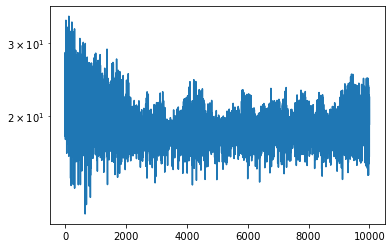

In [24]:
plt.semilogy(np.array(svi_result.losses))

In [25]:
expected["model_04 skill_01 P(csharp)"] = np.array(svi_result.params["skill_p"][0])
expected["model_04 skill_02 P(sql)"] = np.array(svi_result.params["skill_p"][1])

#### Final Result

In [26]:
expected

,IsCorrect1,IsCorrect2,IsCorrect2,P(csharp),P(sql),model_00 P(csharp),model_00 P(sql),model_01a P(csharp),model_01a P(sql),model_01b P(csharp),model_01b P(sql),model_02 P(csharp),model_02 P(sql),model_03 P(csharp),model_03 P(sql),model_04 skill_01 P(csharp),model_04 skill_02 P(sql)
0,False,False,False,0.101,0.101,0.097,0.098,0.099,0.091,0.0013333333,0.49366668,0.094,0.099,0.099,0.091,0.048665,0.059722
1,True,False,False,0.802,0.034,0.799,0.036,0.795,0.031,0.49733335,0.49133334,0.804,0.033,0.795,0.031,0.688575,0.010944
2,False,True,False,0.034,0.802,0.035,0.779,0.034,0.804,0.50366664,0.495,0.032,0.796,0.034,0.804,0.349271,0.444002
3,True,True,False,0.561,0.561,0.544,0.55,0.553,0.547,0.50333333,0.50133336,0.560,0.535,0.553,0.547,0.572850,0.511971
4,False,False,True,0.148,0.148,0.124,0.14,0.15,0.151,0.509,0.489,0.129,0.140,0.150,0.151,0.033702,0.072668
5,True,False,True,0.862,0.326,0.838,0.323,0.862,0.325,0.494,0.499,0.867,0.340,0.862,0.325,0.928674,0.873160
6,False,True,True,0.326,0.862,0.313,0.863,0.33,0.864,0.51133335,0.51666665,0.317,0.857,0.330,0.864,0.044497,0.789204
7,True,True,True,0.946,0.946,0.943,0.944,0.93,0.931,0.496,0.49666667,0.941,0.943,0.930,0.931,0.953621,0.956651


#### model_05
* trying explict config_enumerate
* same as `model_03`

In [27]:
from numpyro.contrib.funsor import config_enumerate

In [28]:
@config_enumerate
def model_05(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1
    
    participants_plate = numpyro.plate("participants_plate", n_participants)
    
    with participants_plate:
        skills = []
        for s in range(n_skills):
            skills.append(numpyro.sample("skill_{}".format(s), dist.Bernoulli(0.5), infer={"enumerate": "parallel"}))

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]])
        prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess
        isCorrect = numpyro.sample(
            "isCorrect_{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )

* trying out `@config_enumeration`, shouldn't work

```python
nuts_kernel = NUTS(model_05)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=1)
mcmc.run(rng_key, responses_check, skills_needed_check)
mcmc.print_summary()

```

```python
AssertionError                            Traceback (most recent call last)
<ipython-input-29-df2927072321> in <module>
      4 
      5 mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=1)
----> 6 mcmc.run(rng_key, responses_check, skills_needed_check)
      7 mcmc.print_summary()

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py in run(self, rng_key, extra_fields, init_params, *args, **kwargs)
    564         map_args = (rng_key, init_state, init_params)
    565         if self.num_chains == 1:
--> 566             states_flat, last_state = partial_map_fn(map_args)
    567             states = tree_map(lambda x: x[jnp.newaxis, ...], states_flat)
    568         else:

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py in _single_chain_mcmc(self, init, args, kwargs, collect_fields)
    353         rng_key, init_state, init_params = init
    354         if init_state is None:
--> 355             init_state = self.sampler.init(
    356                 rng_key,
    357                 self.num_warmup,

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/hmc_gibbs.py in init(self, rng_key, num_warmup, init_params, model_args, model_kwargs)
    439             and site["infer"].get("enumerate", "") != "parallel"
    440         ]
--> 441         assert (
    442             self._gibbs_sites
    443         ), "Cannot detect any discrete latent variables in the model."

AssertionError: Cannot detect any discrete latent variables in the model.
```

* trying again with Predictive

```python
predictive = Predictive(
    model_05,
    num_samples=3000,
    infer_discrete=True,
)
discrete_samples = predictive(rng_key, responses_check, skills_needed_check)
```

```python
ValueError                                Traceback (most recent call last)
<ipython-input-30-96739de38523> in <module>
      4     infer_discrete=True,
      5 )
----> 6 discrete_samples = predictive(rng_key, responses_check, skills_needed_check)

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/util.py in __call__(self, rng_key, *args, **kwargs)
    892             )
    893         model = substitute(self.model, self.params)
--> 894         return _predictive(
    895             rng_key,
    896             model,

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/util.py in _predictive(rng_key, model, posterior_samples, batch_shape, return_sites, infer_discrete, parallel, model_args, model_kwargs)
    737     rng_key = rng_key.reshape(batch_shape + (2,))
    738     chunk_size = num_samples if parallel else 1
--> 739     return soft_vmap(
    740         single_prediction, (rng_key, posterior_samples), len(batch_shape), chunk_size
    741     )

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/util.py in soft_vmap(fn, xs, batch_ndims, chunk_size)
    403         fn = vmap(fn)
    404 
--> 405     ys = lax.map(fn, xs) if num_chunks > 1 else fn(xs)
    406     map_ndims = int(num_chunks > 1) + int(chunk_size > 1)
    407     ys = tree_map(

    [... skipping hidden 15 frame]

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/util.py in single_prediction(val)
    702             model_trace = prototype_trace
    703             temperature = 1
--> 704             pred_samples = _sample_posterior(
    705                 config_enumerate(condition(model, samples)),
    706                 first_available_dim,

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/contrib/funsor/discrete.py in _sample_posterior(model, first_available_dim, temperature, rng_key, *args, **kwargs)
     60     with funsor.adjoint.AdjointTape() as tape:
     61         with block(), enum(first_available_dim=first_available_dim):
---> 62             log_prob, model_tr, log_measures = _enum_log_density(
     63                 model, args, kwargs, {}, sum_op, prod_op
     64             )

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/contrib/funsor/infer_util.py in _enum_log_density(model, model_args, model_kwargs, params, sum_op, prod_op)
    238     result = funsor.optimizer.apply_optimizer(lazy_result)
    239     if len(result.inputs) > 0:
--> 240         raise ValueError(
    241             "Expected the joint log density is a scalar, but got {}. "
    242             "There seems to be something wrong at the following sites: {}.".format(

ValueError: Expected the joint log density is a scalar, but got (2,). There seems to be something wrong at the following sites: {'_pyro_dim_1'}.
```